### Veri setlerimizi import ediyoruz.

In [277]:
from google.colab import files
uploaded = files.upload()

### Gerekli kütüphaneleri import ediyoruz.

In [278]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

### Keşifsel Veri Analizi

In [279]:
# Veri setleri okunuyor.
with open('baraj_aylik.json', 'r') as file:
    baraj_doluluk = json.load(file)

with open('tuketim_aylik.json', 'r') as file:
    su_tuketim = json.load(file)

yagis_ortalamasi_df = pd.read_excel('aylara_gore_toplam_yagis_miktari_ortalamasi.xlsx')
baraj_df = pd.DataFrame(baraj_doluluk['sonuc'])
tuketim_df = pd.DataFrame(su_tuketim)

In [280]:
print('Baraj Doluluk Oranı (ilk beş veri): \n', baraj_df.head(), '\n')
print('Baraj Doluluk Oranı (betimsel istatistikler): \n', baraj_df.describe(), '\n')
print('Aylık Tüketim Oranı (ilk beş veri): \n', tuketim_df.head(), '\n')
print('Aylık Tüketim Oranı (betimsel istatistikler): \n', tuketim_df.describe(), '\n')
print('Aylık Yağış Ortalaması (ilk beş veri): \n', yagis_ortalamasi_df.head(), '\n')
print('Aylık Yağış Ortalaması (betimsel istatistikler): \n', yagis_ortalamasi_df.describe(), '\n')

Baraj Doluluk Oranı (ilk beş veri): 
    barajID olcumTarihi  olcumVerisi
0        2     1999-01     0.525361
1        2     1999-02     0.592521
2        2     1999-03     0.702665
3        2     1999-04     0.801007
4        2     1999-05     0.991861 

Baraj Doluluk Oranı (betimsel istatistikler): 
           barajID  olcumVerisi
count  501.000000   501.000000
mean     1.608782     0.642465
std      0.488511     0.266870
min      1.000000     0.000000
25%      1.000000     0.445910
50%      2.000000     0.674052
75%      2.000000     0.880310
max      2.000000     1.000000 

Aylık Tüketim Oranı (ilk beş veri): 
    aboneSayisi   donem        ilce   tuketim
0         3960  202002  BUYUKORHAN  31141.01
1         3684  202003  BUYUKORHAN  24161.96
2         1757  202004  BUYUKORHAN  15244.45
3         1930  202005  BUYUKORHAN  27307.87
4         3932  202006  BUYUKORHAN  38522.41 

Aylık Tüketim Oranı (betimsel istatistikler): 
          aboneSayisi          donem       tuketim
count  

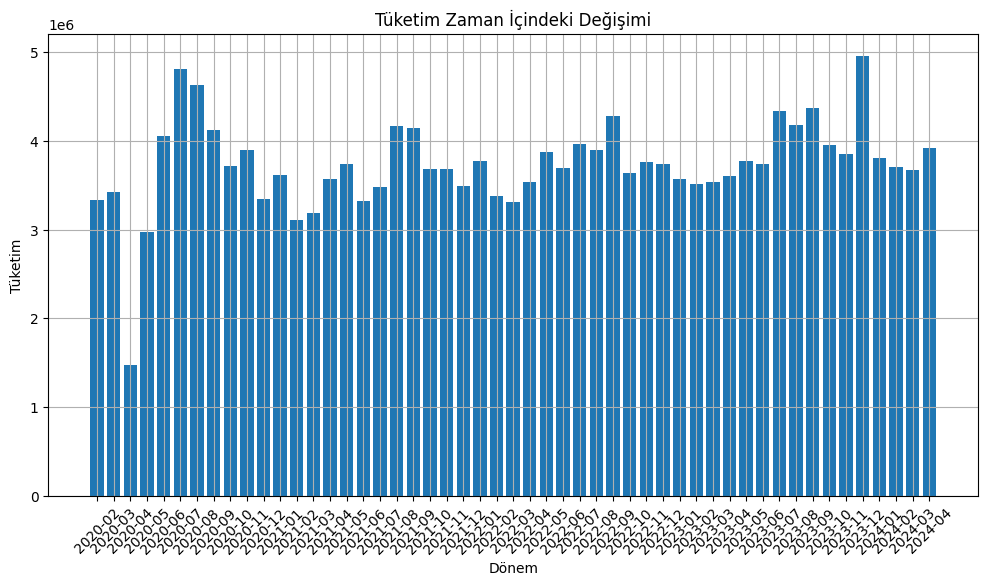

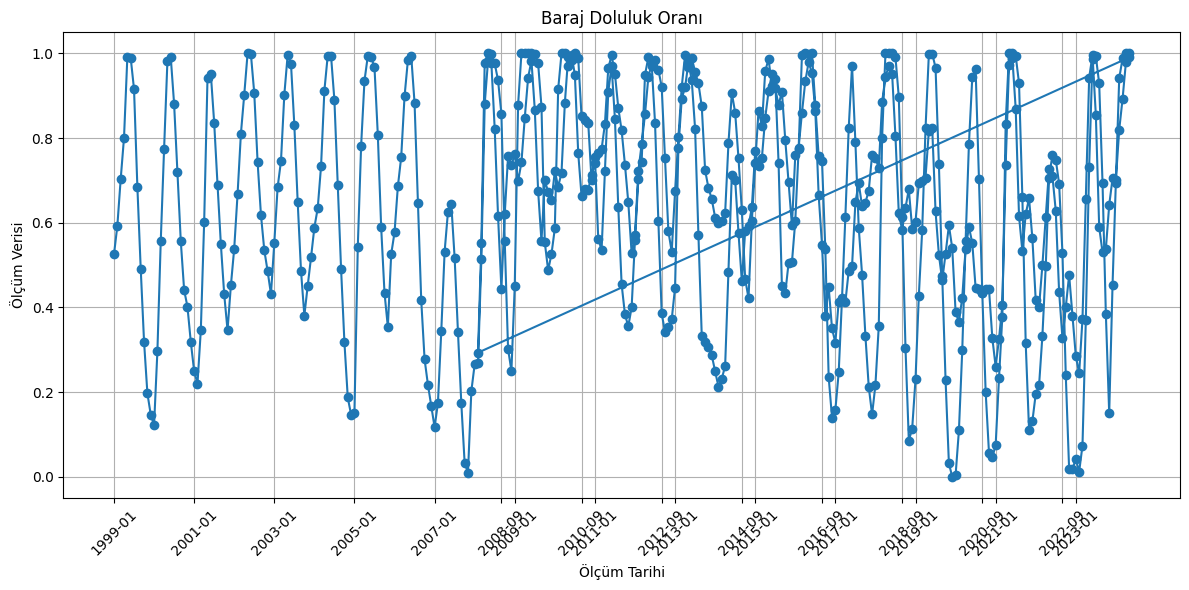

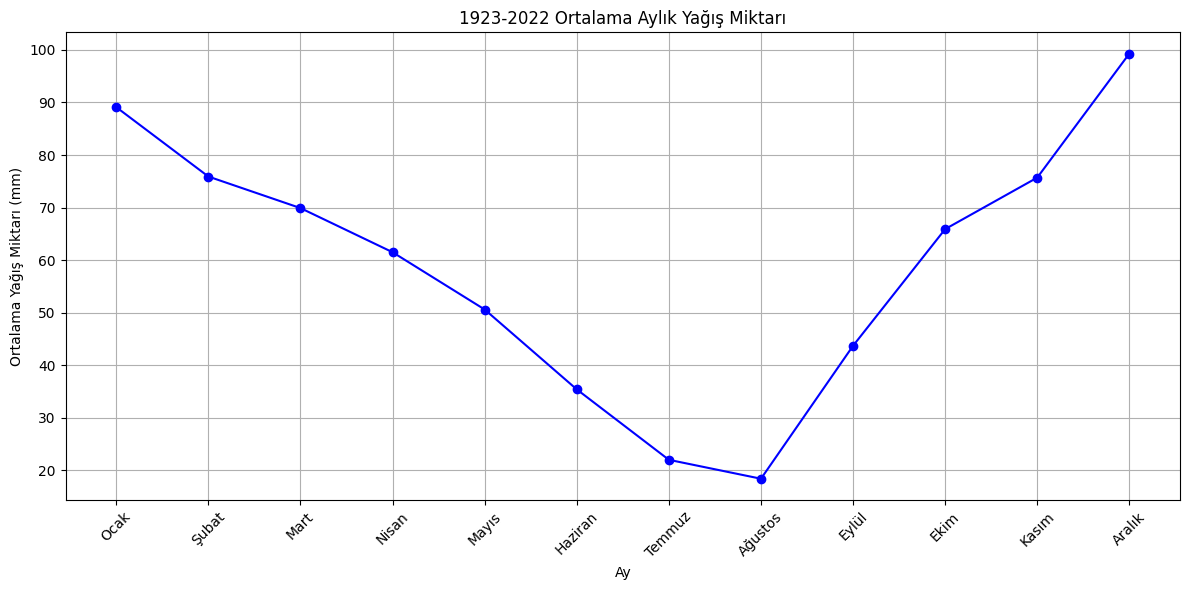

In [281]:
# Aylık tüketim verileri dönem bazlı olarak indirgeniyor
tuketim_df['donem_str'] = tuketim_df['donem'].astype(str)
tuketim_df['yil'] = tuketim_df['donem_str'].str[:4]
tuketim_df['ay'] = tuketim_df['donem_str'].str[4:]

# Aylık tüketim verisine ait çubuk grafik çiziliyor
plt.figure(figsize=(12, 6))
plt.bar(tuketim_df['yil'] + '-' + tuketim_df['ay'], tuketim_df['tuketim'])
plt.xlabel('Dönem')
plt.ylabel('Tüketim')
plt.title('Tüketim Zaman İçindeki Değişimi')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Baraj doluluk verisine ait çizgi grafik çiziliyor
plt.figure(figsize=(12, 6))
plt.plot(baraj_df["olcumTarihi"], baraj_df["olcumVerisi"], marker='o', linestyle='-')
plt.xticks(baraj_df["olcumTarihi"][::24], rotation=45)
plt.grid(True)
plt.xlabel('Ölçüm Tarihi')
plt.ylabel('Ölçüm Verisi')
plt.title('Baraj Doluluk Oranı')
plt.tight_layout()
plt.show()

# Yağış ortalamasına ait çizgi grafik çiziliyor
plt.figure(figsize=(12, 6))
plt.plot(yagis_ortalamasi_df['AY'], yagis_ortalamasi_df['TOPLAM_YAGIS_MIKTARI_ORTALAMASI_MM_1923_2022'], marker='o', color='b', linestyle='-')
plt.xlabel('Ay')
plt.ylabel('Ortalama Yağış Miktarı (mm)')
plt.title('1923-2022 Ortalama Aylık Yağış Miktarı')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Veri Ön İşleme

In [282]:
tuketim_df['ay'] = tuketim_df['donem'].astype(str).str[-2:]
# İlçe bazlı olan aylık su tüketim verileri iz bazlı olması için gerekli işleme tabi tutularak gruplandırılıyor.
tuketim_grouped = tuketim_df.groupby('donem').agg({'aboneSayisi': 'sum', 'tuketim': 'sum'}).reset_index()
# Su tüketim verisindeki bulunan tarihler ile aynı olması için baraj doluluk oranları verisine tarih filtresi uygulanıyor.
baraj_filtreli = baraj_df[(baraj_df["olcumTarihi"] >= "2020-02") & (baraj_df["olcumTarihi"] <= "2024-04")].reset_index(drop=True)

In [283]:
# Tarih verileri gerekli şekilde formatlanıyor.
tuketim_grouped['donem'] = pd.to_datetime(tuketim_grouped['donem'], format='%Y%m')
baraj_filtreli['olcumTarihi'] = pd.to_datetime(baraj_filtreli['olcumTarihi'], format='%Y-%m')

tuketim_grouped['year_month'] = pd.to_datetime(tuketim_grouped['donem']).dt.to_period('M')

month_dict = {
    1: 'Ocak',
    2: 'Şubat',
    3: 'Mart',
    4: 'Nisan',
    5: 'Mayıs',
    6: 'Haziran',
    7: 'Temmuz',
    8: 'Ağustos',
    9: 'Eylül',
    10: 'Ekim',
    11: 'Kasım',
    12: 'Aralık'
}

tuketim_grouped['AY'] = pd.to_datetime(tuketim_grouped['donem']).dt.month.map(month_dict)

# Aylık yağış ortalamaları verisi ile aylık su tüketim verisi birleştirilerek X dataframe'i hazırlanıyor.
merged_df = tuketim_grouped.merge(yagis_ortalamasi_df, on='AY', how='left')
merged_df = merged_df.drop(columns=['AY', 'year_month'])

### Model Seçimi

In [284]:
# İki farklı baraja ait tahmin yapılacağı için y için iki farklı dataframe oluşturuluyor.
X = merged_df[['tuketim', 'TOPLAM_YAGIS_MIKTARI_ORTALAMASI_MM_1923_2022']]
y_baraj1 = baraj_filtreli[baraj_filtreli['barajID'] == 1].copy()['olcumVerisi']
y_baraj2 = baraj_filtreli[baraj_filtreli['barajID'] == 2].copy()['olcumVerisi']

# RandomForestRegressor modelinin kullanılmasına karar verildi

In [285]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_baraj1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y_baraj2, test_size=0.2, random_state=42)

### Hiperparametre Optimizasyonu

In [286]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor()

# RandomizedSearchCV ile hiperparametre optimizasyonu
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

for i, (X_train, y_train, X_test, y_test) in enumerate([(X_train_1, y_train_1, X_test_1, y_test_1), (X_train_2, y_train_2, X_test_2, y_test_2)]):
    rf_random.fit(X_train, y_train)
    print(f"En iyi parametreler ({i+1}. veri seti):", rf_random.best_params_)
    print(f"En iyi skor ({i+1}. veri seti):", rf_random.best_score_)

    best_model = rf_random.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f'Mean Squared Error ({i+1}. veri seti):', mean_squared_error(y_test, y_pred))
    print(f'R-squared ({i+1}. veri seti):', r2_score(y_test, y_pred))

# İki baraj için de Hiperparametre Optimizasyonu uygulanarak en iyi model parametreleri bulunuyor.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


En iyi parametreler (1. veri seti): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
En iyi skor (1. veri seti): 0.4625264146562816
Mean Squared Error (1. veri seti): 0.01695415183897779
R-squared (1. veri seti): 0.7760569164525567
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


En iyi parametreler (2. veri seti): {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
En iyi skor (2. veri seti): 0.3441455404250881
Mean Squared Error (2. veri seti): 0.016116289434396566
R-squared (2. veri seti): 0.6487240529590386


### Model Değerlendirme

In [287]:
# Baraj 1 için model kurularak tahmin oluşturuluyor.

best_model_baraj1 = RandomForestRegressor(n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=70, bootstrap=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_baraj1, test_size=0.2, random_state=42)

best_model_baraj1.fit(X_train, y_train)

y_pred_baraj1 = best_model_baraj1.predict(X_test)

print('Baraj 1 Mean Squared Error:', mean_squared_error(y_test, y_pred_baraj1))
print('Baraj 1 R-squared:', r2_score(y_test, y_pred_baraj1))

# Baraj 2 için model kurularak tahmin oluşturuluyor.

best_model_baraj2 = RandomForestRegressor(n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=None, bootstrap=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_baraj2, test_size=0.2, random_state=42)

best_model_baraj2.fit(X_train, y_train)

y_pred_baraj2 = best_model_baraj2.predict(X_test)

print('Baraj 2 Mean Squared Error:', mean_squared_error(y_test, y_pred_baraj2))
print('Baraj 2 R-squared:', r2_score(y_test, y_pred_baraj2))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Baraj 1 Mean Squared Error: 0.018547190997428024
Baraj 1 R-squared: 0.7550148670039375


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Baraj 2 Mean Squared Error: 0.015778636032006268
Baraj 2 R-squared: 0.656083657611156
